# Definitions

The numerical eqn to solve is to minimize the energy

$$
 E = K_u (d_1 \sin^2\psi_1 + d_2\sin^2\psi_2) - \mu_0  H [d_1M_s^1\cos(\theta_H-\psi_1)+d_2M_s^2\cos(\theta_H-\psi_2)] - J_1 \cos(\psi_1-\psi_2) - J_2 \cos^2(\psi_1-\psi_2)
$$ 

In [ ]:
def energy(psi1, psi2, J1, J2, H):
    term1 = Ku * (d1*np.sin(psi1)**2 + d2*np.sin(psi2)**2)
    term2 = - mu0 * H * (d1*Ms1*np.cos(thH - psi1) + d2*Ms2*np.cos(thH - psi2))
    term3 = - J1 * np.cos(psi1 - psi2)- J2 * np.cos(psi1 - psi2)**2

    return (term1 + term2 + term3)/((d1 + d2)*mu0*((Ms1 + Ms2)/2)**2)

Minimze allows to minimize one or more variable functions. Allows for different methods and gives the point
- res.x = x value that minimizes f
- res.fun = minimum f value at res.x
- can take multi-variable functions
- Example usage : 

In [ ]:
from scipy.optimize import minimize

def f(v):
    x = v[0]
    y = v[1]
    return y* np.cos(x**2+y) + np.sin(x)*np.sin(3*x)*(1-x)**x

res = minimize(f, x0=[1e-2,2], method='L-BFGS-B', bounds=None)
print(res)

  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: -3.288371395590855
        x: [ 1.007e-07  3.426e+00]
      nit: 7
      jac: [ 8.882e-07 -8.882e-08]
     nfev: 27
     njev: 9
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


In [ ]:
from scipy.optimize import minimize
from numpy import pi 

def minimize_energy(J1, J2, H, initial_guesses=None, bounds=None, method='L-BFGS-B', n_restarts=25):

    if initial_guesses is None:
        # a set of deterministic starting points + some random
        grid = [(0,0), (pi/2, pi/2), (pi, -pi/2), (-pi/2, pi/4)]
        rng = np.random.RandomState(0)
        for _ in range(max(0, n_restarts - len(grid))):
            grid.append((rng.uniform(-pi,pi), rng.uniform(-pi,pi)))
        initial_guesses = grid

    best = {'Emin': np.inf, 'psi1': None, 'psi2': None, 'success': False}
    for x0 in initial_guesses:
        def f(x):
            return energy(x[0], x[1], J1, J2, H)

        # bounds for psi angles if provided
        res = minimize(f, x0=np.array(x0), method=method, bounds=bounds)
        if res.success and res.fun < best['Emin'] - 1e-7:
            best.update({'Emin': float(res.fun), 'psi1': float(res.x[0]), 'psi2': float(res.x[1]), 'success': True})
        elif not res.success:
            # keep the value anyway in case it's lower
            if res.fun < best['Emin']:
                best.update({'Emin': float(res.fun), 'psi1': float(res.x[0]), 'psi2': float(res.x[1]), 'success': False})

    return best

In [ ]:
from scipy.optimize import least_squares

m_mean = ( Ms1*d1  + Ms2*d2 )/(d1+d2)

# this is the observable that I can fit with the experimental data in Ms units
def observable(res):
    psi1 = res['psi1']
    psi2 = res['psi2']
    m = Ms1 *d1/(d1+d2) * np.cos(psi1-thH) + Ms2 *d2/(d1+d2)*np.cos(psi2-thH) 
    return m

# residuals function for least squares fitting
def residuals_for_fit(J, H_exp, M_exp):
    J1, J2 = J
    res_list = []

    # for each H in the list of experimental measurements H_exp, compute the calculated M and compare with M_exp
    for i, H in enumerate(H_exp):
        min_res = minimize_energy(J1, J2, H)
        M_calc = observable(min_res)
        M_sim = M_exp[i]
        
        res_list.append(((M_calc - M_sim)/m_mean)**2)  # difference
    
    return np.array(res_list)


In [ ]:
from scipy.optimize import differential_evolution

def best_J(lower_bounds, upper_bounds, h_vals, m_vals):
    def cost(J):
        return np.sum(residuals_for_fit(J, h_vals, m_vals))
    
    result = differential_evolution(cost, bounds=list(zip(lower_bounds, upper_bounds)), maxiter=30, popsize=8)
    status_global = result

    guess = result.x

    refined_result = least_squares(
        residuals_for_fit,
        x0=guess,
        bounds=(lower_bounds, upper_bounds),
        args=(h_vals, m_vals),
        xtol=1e-7,
        ftol=1e-7,
        max_nfev=5000
    )
    
    
    status_refined = refined_result
    best_params = refined_result.x

    return best_params , status_global, status_refined

In [ ]:
def hystersis(h_vals, J1, J2):
    m_vals = []
    psi1_vals = []
    psi2_vals = []
    for H in h_vals:
        res = minimize_energy(J1, J2, H)
        m = observable(res)
        m_vals.append(m)

        psi1 = res['psi1']
        psi1 = psi1 % ( 2* np.pi)
        psi2 = res['psi2']
        psi2 = psi2 % ( 2* np.pi)

        psi1_vals.append(psi1)
        psi2_vals.append(psi2)


    return np.array(m_vals), np.array(psi1_vals), np.array(psi2_vals)

# Calculations

In [ ]:
import numpy as np

Ku = 0
mu0 = 4e-7 * np.pi
Ms1 = 7.4e5
Ms2 = 7.4e5
d1 = 5e-9
d2 = 15e-9
thH = 0

In [ ]:
hmax = 1e-7/mu0
H_vals = np.linspace(-hmax, hmax, 35)
J1 = -0.00056132
J2 = -0.00078135
Ku =  0
mx_num, psi1_vals, psi2_vals = hystersis(H_vals, J1, J2)

In [ ]:
# np.savez("rkky-3e-5_data.npz", H_vals=H_vals, psi1_vals=psi1_vals, psi2_vals=psi2_vals)

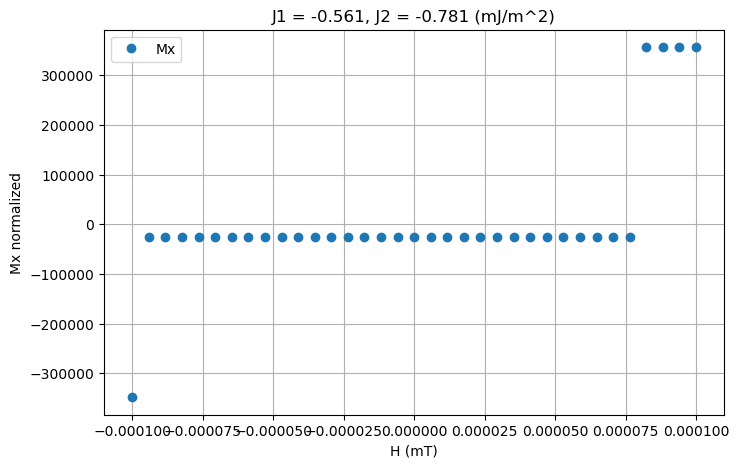

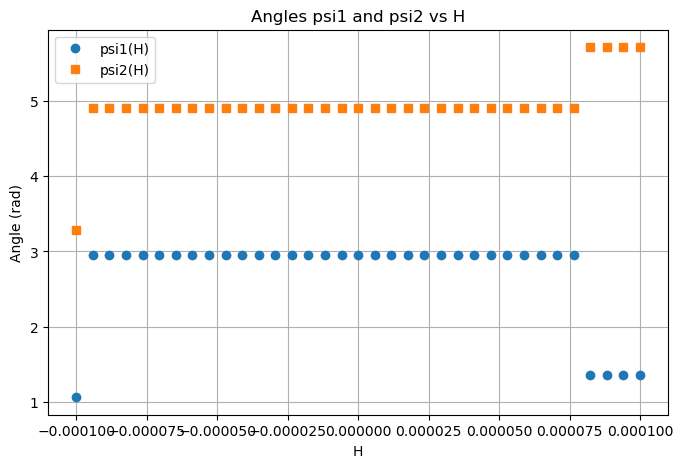

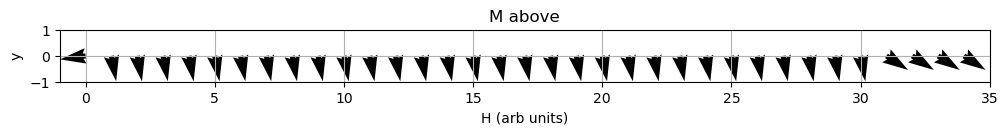

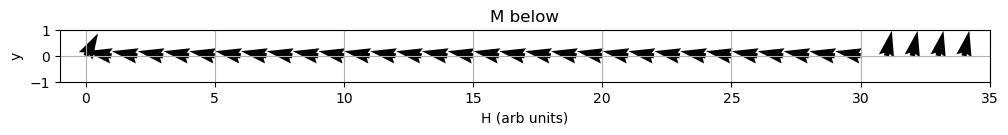

In [ ]:
import matplotlib.pyplot as plt


# Plot magnetization
plt.figure(figsize=(8,5))
plt.plot(H_vals*mu0*1e3, mx_num, 'o', label='Mx')
plt.xlabel('H (mT)')
plt.ylabel('Mx normalized')
plt.title(f'J1 = {round(J1*1e3,3)}, J2 = {round(J2*1e3,3)} (mJ/m^2)')
plt.grid(True)
plt.legend()
plt.show()

psi1_mod = []
sim_axis = np.pi
for psi in psi1_vals:
    if psi > sim_axis:
        psi1_mod.append(sim_axis-(psi-sim_axis))
    else:
        psi1_mod.append(psi)

psi2_mod = []
for psi in psi2_vals:
    if psi < sim_axis:
        psi2_mod.append(sim_axis+(sim_axis-psi))
    else:
        psi2_mod.append(psi)
'''
#Optional: plot psi1 and psi2 vs H
plt.figure(figsize=(8,5))
plt.plot(H_vals, psi1_vals, 'o', label='psi1(H)')
plt.plot(H_vals, psi2_vals, 's', label='psi2(H)')
plt.xlabel('H')
plt.ylabel('Angle (rad)')
plt.title('Angles psi1 and psi2 vs H')
plt.grid(True)
plt.legend()
plt.show()

'''
# Optional: plot psi1 and psi2 vs H
plt.figure(figsize=(8,5))
plt.plot(H_vals*mu0*1e3, psi1_mod, 'o', label='psi1(H)')
plt.plot(H_vals*mu0*1e3, psi2_mod, 's', label='psi2(H)')
plt.xlabel('H')
plt.ylabel('Angle (rad)')
plt.title('Angles psi1 and psi2 vs H')
plt.grid(True)
plt.legend()
plt.show()

# Compute arrow components
u = np.cos(psi1_mod)   # x-components
v = np.sin(psi1_mod)   # y-components

# Arrow origins: spread along x-direction
x0 = np.arange(len(psi1_mod))
y0 = np.zeros_like(psi1_mod)

u2 = np.cos(psi2_mod)   # x-components
v2 = np.sin(psi2_mod)   # y-components

# Arrow origins: spread along x-direction
x02 = np.arange(len(psi2_mod))
y02 = np.zeros_like(psi2_mod)


plt.figure(figsize=(12, 3))
plt.quiver(x02, y02, u2, v2, angles='xy', scale_units='xy', scale=1)
plt.xlim(-1, len(psi1_mod))
plt.ylim(-1, 1)
plt.gca().set_aspect('equal')
plt.title("M above")
plt.xlabel("H (arb units)")
plt.ylabel("y")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 3))
plt.quiver(x0, y0, u, v, angles='xy', scale_units='xy', scale=1)
plt.xlim(-1, len(psi1_mod))
plt.ylim(-1, 1)
plt.gca().set_aspect('equal')
plt.title("M below")
plt.xlabel("H (arb units)")
plt.ylabel("y")
plt.grid(True)
plt.show()

In [ ]:
hmax = 4e-2/mu0
H_vals = np.linspace(-hmax, hmax, 100)
J1 = -4e-5
J2 = 1e-6
Ku =  0
mx_num, psi1_vals, psi2_vals = hystersis(H_vals, J1, J2)

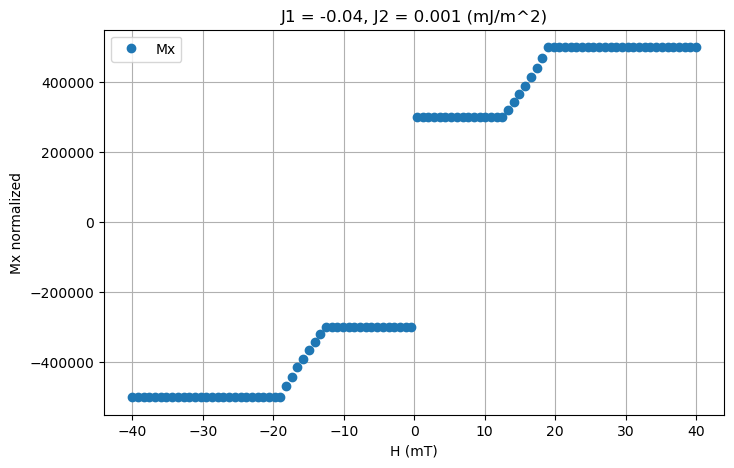

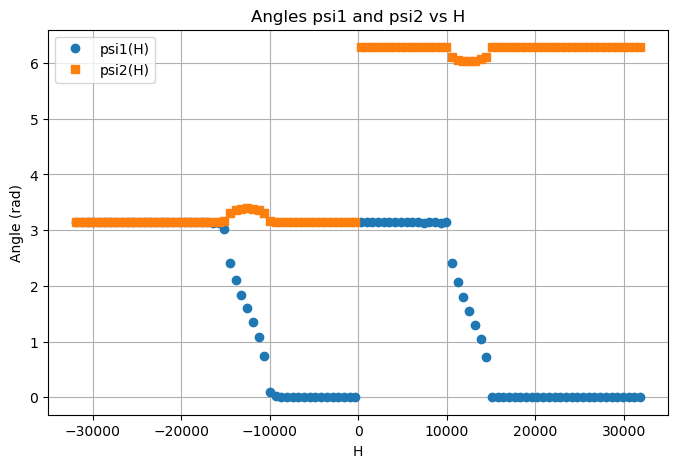

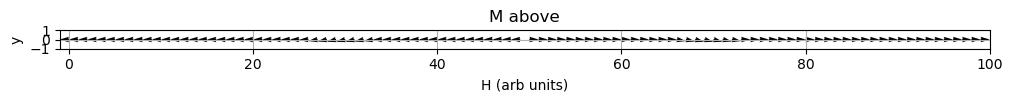

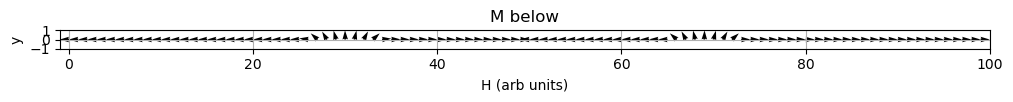

In [ ]:
import matplotlib.pyplot as plt


# Plot magnetization
plt.figure(figsize=(8,5))
plt.plot(H_vals*mu0*1e3, mx_num, 'o', label='Mx')
plt.xlabel('H (mT)')
plt.ylabel('Mx normalized')
plt.title(f'J1 = {round(J1*1e3,3)}, J2 = {round(J2*1e3,3)} (mJ/m^2)')
plt.grid(True)
plt.legend()
plt.show()

psi1_mod = []
sim_axis = np.pi
for psi in psi1_vals:
    if psi > sim_axis:
        psi1_mod.append(sim_axis-(psi-sim_axis))
    else:
        psi1_mod.append(psi)

psi2_mod = []
for psi in psi2_vals:
    if psi < sim_axis:
        psi2_mod.append(sim_axis+(sim_axis-psi))
    else:
        psi2_mod.append(psi)
'''
#Optional: plot psi1 and psi2 vs H
plt.figure(figsize=(8,5))
plt.plot(H_vals, psi1_vals, 'o', label='psi1(H)')
plt.plot(H_vals, psi2_vals, 's', label='psi2(H)')
plt.xlabel('H')
plt.ylabel('Angle (rad)')
plt.title('Angles psi1 and psi2 vs H')
plt.grid(True)
plt.legend()
plt.show()

'''
# Optional: plot psi1 and psi2 vs H
plt.figure(figsize=(8,5))
plt.plot(H_vals, psi1_mod, 'o', label='psi1(H)')
plt.plot(H_vals, psi2_mod, 's', label='psi2(H)')
plt.xlabel('H')
plt.ylabel('Angle (rad)')
plt.title('Angles psi1 and psi2 vs H')
plt.grid(True)
plt.legend()
plt.show()

# Compute arrow components
u = np.cos(psi1_mod)   # x-components
v = np.sin(psi1_mod)   # y-components

# Arrow origins: spread along x-direction
x0 = np.arange(len(psi1_mod))
y0 = np.zeros_like(psi1_mod)

u2 = np.cos(psi2_mod)   # x-components
v2 = np.sin(psi2_mod)   # y-components

# Arrow origins: spread along x-direction
x02 = np.arange(len(psi2_mod))
y02 = np.zeros_like(psi2_mod)


plt.figure(figsize=(12, 3))
plt.quiver(x02, y02, u2, v2, angles='xy', scale_units='xy', scale=1)
plt.xlim(-1, len(psi1_mod))
plt.ylim(-1, 1)
plt.gca().set_aspect('equal')
plt.title("M above")
plt.xlabel("H (arb units)")
plt.ylabel("y")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 3))
plt.quiver(x0, y0, u, v, angles='xy', scale_units='xy', scale=1)
plt.xlim(-1, len(psi1_mod))
plt.ylim(-1, 1)
plt.gca().set_aspect('equal')
plt.title("M below")
plt.xlabel("H (arb units)")
plt.ylabel("y")
plt.grid(True)
plt.show()

In [ ]:
# example data for fitting 

hmax = 1/mu0
H_vals = np.linspace(-hmax, hmax, 50)
J1 = -5e-4
J2 = 0

psi1_vals = []
psi2_vals = []
M_vals = []
for H in H_vals:
    # minimize energy for current field
    res = minimize_energy(J1, J2, H)
    
    psi1 = res['psi1']
    psi2 = res['psi2']
    
    # store angles
    psi1_vals.append(psi1)
    psi2_vals.append(psi2)
    
    # compute magnetization
    M = (Ms1 * np.cos(psi1 - thH) + Ms2 * np.cos(psi2 - thH)) /2
    M_vals.append(M)

M_vals = np.array(M_vals)


lower_bounds = [-1.5e-3, -1.5e-3]
upper_bounds = [0, 1.5e-3]

# params , status_global, status_refined = best_J(lower_bounds, upper_bounds, H_vals, M_vals)

In [ ]:
# mx_num, psi1_num, psi2_num = hystersis(H_vals, params[0], params[1])

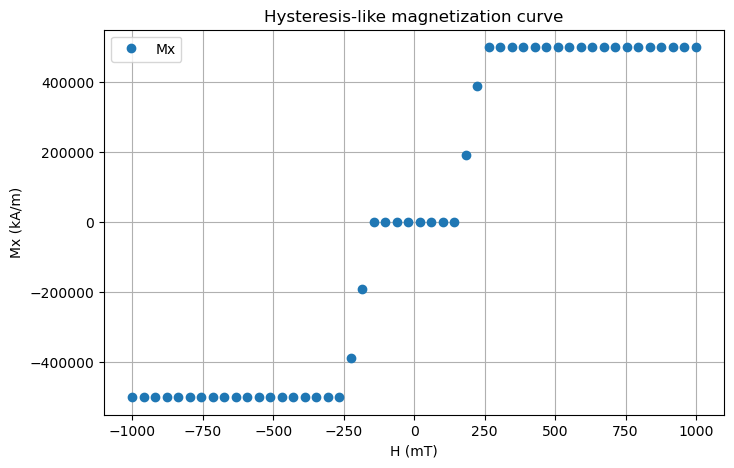

In [ ]:
import matplotlib.pyplot as plt


# Plot magnetization
plt.figure(figsize=(8,5))
plt.plot(H_vals*mu0*1e3, M_vals, 'o', label='Mx')
# plt.plot(H_vals*mu0*1e3, mx_num, 'o', label='Mx_fit')
plt.xlabel('H (mT)')
plt.ylabel('Mx (kA/m)')
plt.title('Hysteresis-like magnetization curve')
plt.grid(True)
plt.legend()
plt.show()


# DATA FROM SIMULATIONS

In [16]:
# sample1
import numpy as np
import pandas as pd
import os

thH = 0

d1 = 15e-9
d2_v = [1.5e-9, 2.5e-9, 5e-9, 7.5e-9, 10e-9, 15e-9]

Msm = [620, 530, 370, 245, 0, 0]
Msp = [690, 714, 740, 743 , 0, 0]

Ms1_v = []
Ms2_v = []

for i, d in enumerate(d2_v):
    d2 = d

    A = np.array([[d1/(d1+d2), -d2/(d1+d2)],
                [d1/(d1+d2),  d2/(d1+d2)]])
    b = np.array([Msm[i]*1e3, Msp[i]*1e3])
    M1, M2 = np.linalg.solve(A, b)

    Ms1_v.append(M1)
    Ms2_v.append(M2)

Ms1_v[-1] = Ms2_v[-1] = np.float64(770*1e3)
Ms1_v[-2] = Ms2_v[-2] = np.float64(788*1e3)

files = [
    "py15ru0.95py1.5.csv",
    "py15ru0.95py2.5.csv",
    "py15ru0.95py5.csv",
    "py15ru0.95py7.5.csv",
    "py15ru0.95py10.csv",
    "py15ru0.95py15.csv",
]
res = {}
# Ruta relativa desde la carpeta del notebook a la carpeta de datos
for i, (d2, file) in enumerate(zip(d2_v, files)):
    Ms1 = Ms1_v[i]
    Ms2 = Ms2_v[i]

    file_path = os.path.join("..", "Measurements", file)
    df = pd.read_csv(file_path, sep=',')

    # obtain field and Ms from file
    Field_array = df['Field'].to_numpy() # field in Oe
    Ms_array = df['M/cm3'].to_numpy() 

    # erase values in between (the model does not well describe the hysteresis)
    cut = 10
    field = np.array([*Field_array[1:59-cut:3],*Field_array[59+cut:118:3]], dtype = float)*(1/(mu0*1e4)) # field in T
    Ms = np.array([*Ms_array[1:59-cut:3],*Ms_array[59+cut:118:3]])*1e3  # Ms in A/m

    lower_bounds = [-1e-4, -1e-4]
    upper_bounds = [0, 1e-4]

    #parms , status_global, status_refined = best_J(lower_bounds, upper_bounds, field, Ms)
    #res[d2] = parms

print(res)

KeyError: 'M/cm3'

In [17]:
%matplotlib widget

In [18]:
from numpy import array 
res = {1.5e-09: array([-5.18495322e-05, -2.12244788e-06]), 2.5e-09: array([-7.17872313e-05, -4.54224331e-06]), 5e-09: array([-7.93531368e-05, -3.02820016e-06]), 7.5e-09: array([-9.16251828e-05, -1.81685080e-06]), 1e-08: array([-9.46026223e-05, -1.71785576e-06]), 1.5e-08: array([-9.99999003e-05, -2.86326067e-06])}

[np.float64(720500.0),
 np.float64(725666.6666666666),
 np.float64(740000.0000000001),
 np.float64(740999.9999999999),
 np.float64(788000.0),
 np.float64(770000.0)]

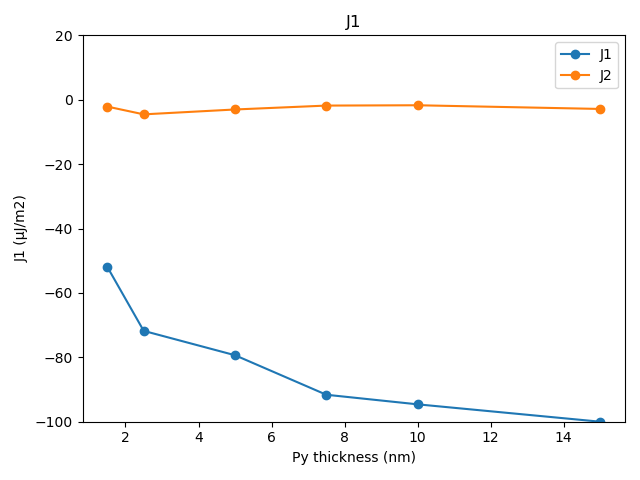

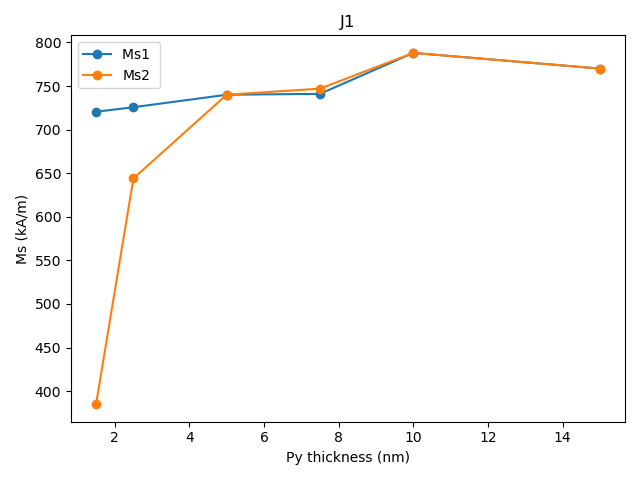

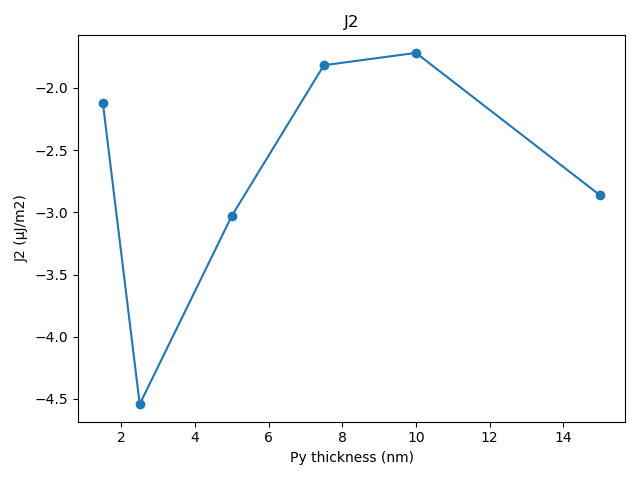

In [59]:
# sort by thickness
d = np.array(sorted(res.keys()))
J1 = np.array([res[x][0] for x in d])
J2 = np.array([res[x][1] for x in d])

# plot thickness vs J1
plt.figure()
plt.title('J1')
plt.plot(d*1e9, J1*1e6, 'o-', label = 'J1')
plt.plot(d*1e9, J2*1e6, 'o-', label = 'J2')
plt.ylim(-100,20)
plt.legend()
plt.xlabel("Py thickness (nm)")
plt.ylabel("J1 (μJ/m2)")
plt.tight_layout()
plt.show()

plt.figure()
plt.title('J1')
plt.plot(d*1e9, np.array(Ms1_v)*1e-3, 'o-', label = 'Ms1 ')
plt.plot(d*1e9, np.array(Ms2_v)*1e-3, 'o-', label = 'Ms2')
plt.legend()
plt.xlabel("Py thickness (nm)")
plt.ylabel("Ms (kA/m)")
plt.tight_layout()
plt.show()

# plot thickness vs J2
plt.figure()
plt.title('J2')
plt.plot(d*1e9, J2*1e6, 'o-')

plt.xlabel("Py thickness (nm)")
plt.ylabel("J2 (μJ/m2)")
plt.tight_layout()
plt.show()

In [50]:
#Ms1 = 734e3
#Ms2 = 650e3
sample =2

d1 = 15e-9
d2 = d2_v[sample]
thH = 0

Ms1 = Ms1_v[sample]
Ms2 = Ms2_v[sample]

file_path = os.path.join("..", "Measurements", files[sample])

df = pd.read_csv(file_path, sep=',')
df.head()
Field_array = df['Field'].to_numpy() # field in Oe
Ms_array = df['M/cm3'].to_numpy() 

cut = 0
field = np.array([*Field_array[1:59-cut],*Field_array[59+cut:118]], dtype = float)*(1/(mu0*1e4)) # field in T
Ms = np.array([*Ms_array[1:59-cut],*Ms_array[59+cut:118]])*1e3  # Ms in A/m

J = res[d2]
print('sample: d2 =',round(d2, 1))
print(J)

sample: d2 = 0.0
[-7.93531368e-05 -3.02820016e-06]


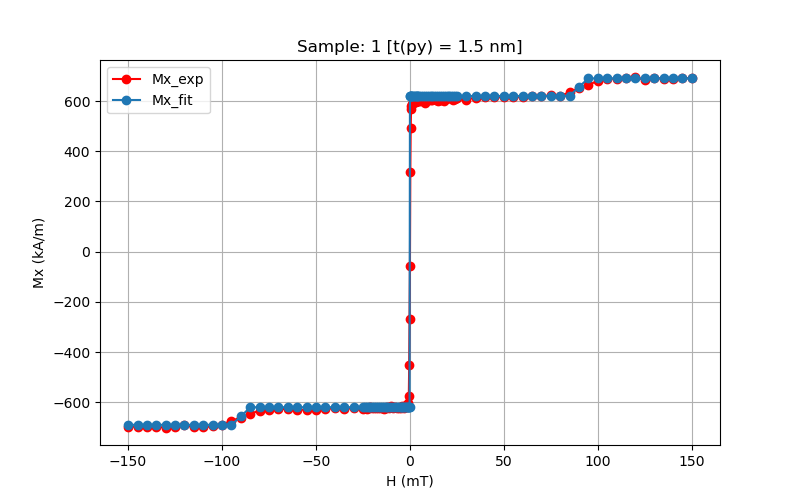

In [49]:
import matplotlib.pyplot as plt

J1, J2 = J[0], 0
psi1_vals = []
psi2_vals = []
M_vals_num = []

psi1, psi2 = [-pi, -pi]

for H in field:
    # minimize energy for current field
    
    result = minimize_energy(J1, J2, H)
    
    psi1 = result['psi1']
    psi1 = psi1 % ( 2* np.pi)

    psi2 = result['psi2']
    psi2 = psi2 % (2* np.pi)

    # store angles
    psi1_vals.append(psi1)
    psi2_vals.append(psi2)
    
    # compute magnetization
    M = Ms1*d1/(d1+d2) * np.cos(psi1-thH) + Ms2 *d2/(d1+d2)*np.cos(psi2-thH) 
    M_vals_num.append(M)

# Convert lists to arrays
psi1_vals = np.array(psi1_vals)
psi2_vals = np.array(psi2_vals)
M_vals_num = np.array(M_vals_num)

for psi in psi1_vals:
    if psi > np.pi:
        psi = psi1_vals - 2* np.pi

# Plot magnetization
plt.figure(figsize=(8,5))
plt.plot(mu0*field*1e3, Ms*1e-3, 'o-', color = 'red', label='Mx_exp')
plt.plot(mu0*field*1e3, M_vals_num*1e-3, 'o-', label='Mx_fit')
#plt.xlim(30,150)
#plt.ylim(500,750)
plt.xlabel('H (mT)')
plt.ylabel('Mx (kA/m)')
plt.title(f'Sample: {sample +1} [t(py) = {round(d2*1e9,1)} nm]')
plt.grid(True)
plt.legend()
plt.show()
